<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score 

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Удалим столбец **Surname**, поскольку индентификация пользователя у нас остается в числовом столбце **CustomerId**

In [4]:
df = df.drop(['Surname'], axis = 1)

Заменим пропуски в колонке *Tenure* на случайные значения, посл=кольку причина пропусков нам не звестна, а простая замена на 0 может повлиять на распределение

In [5]:
df['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [6]:
df['Tenure'] = df['Tenure'].mask(df['Tenure'].isna(), np.random.uniform(1, 10, size=len(df))).astype('int64')

df['Tenure'].describe()

count    10000.000000
mean         4.993200
std          2.874296
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

С помощью *техники OHE* подготовим данные из столбцов **Gender** и **Geography**. Используем параметр *drop_first=True*, чтобы избежать дамми-ловушки.

In [7]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [8]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [9]:
df_ohe = pd.get_dummies(df, columns = ['Gender', 'Geography'], drop_first=True)
df_ohe

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,9997,15569892,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,9998,15584532,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,9999,15682355,772,42,3,75075.31,2,1,0,92888.52,1,1,1,0


Разделим выборки на обучающую, тестовую и валидационную и проведем масштабирование признаков

In [10]:
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

In [11]:
print('Размер выборки _train', features_train.shape)
print('Размер выборки _valid', features_valid.shape)
print('Размер выборки _test', features_test.shape)

Размер выборки _train (6000, 13)
Размер выборки _valid (2000, 13)
Размер выборки _test (2000, 13)


In [12]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

features_valid.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
8532,8533,15780805,-0.699824,-0.373192,-1.054919,-1.233163,2,1,0,-0.015173,0,0,0
5799,5800,15649853,-0.284431,0.575842,-0.705878,-1.233163,1,1,1,1.471724,0,0,0
5511,5512,15714970,0.151731,-0.657902,-1.753002,0.438711,1,1,0,-1.367107,1,1,0
7365,7366,15593178,-0.876366,-0.278288,1.737412,1.239884,1,1,1,-0.786517,0,0,1
7367,7368,15736399,-0.481743,0.291132,1.737412,-1.233163,2,1,0,1.358533,1,0,1


## Исследование задачи

Баланс класса выглядит следующим образом

In [13]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Для выбора лучшей модели выберем лучшие гиперпараметры решающего дерева DecisionTreeClassifier и случайоного леса RandomForestClassifier

In [14]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions) 
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth


print("f1_score лучшей модели DT на валидационной выборке:", best_result)
print("Depth лучшей модели:", best_depth)

f1_score лучшей модели DT на валидационной выборке: 0.5528700906344411
Depth лучшей модели: 4


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth) 
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("roc_auc лучшей модели DT на валидационной выборке:", auc_roc)

roc_auc лучшей модели DT на валидационной выборке: 0.815352439828453


Для *RandomForestClassifier* будем использовать следующие параметры:

- n_estimators – число деревьев в лесу. Оно будет изменяться от 1 до 20 с шагом 2
- max_depth – глубина дерева. Она будет изменяться от 1 до 12 с шагом в 2.

Для подбора параметров используем *GridSearchCV*, который находит наилучшие параметры путем обычного перебора: он создает модель для каждой возможной комбинации параметров.

In [18]:
model_rf = RandomForestClassifier() 

parametrs = { 'n_estimators': range (1, 21, 2),
              'max_depth': range (1,13, 2) }
grid = GridSearchCV(model_rf, parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 9, 'n_estimators': 19}

In [100]:
model_best = RandomForestClassifier(
    random_state=12345, max_depth = 11, n_estimators = 17)

model_best.fit(features_train, target_train) 
predictions = model_best.predict(features_valid)
result = f1_score(target_valid, predictions)

probabilities_valid = model_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("roc_auc лучшей модели DT на валидационной выборке:", auc_roc)
print("f1_score лучшей модели RF на валидационной выборке:", result)

roc_auc лучшей модели DT на валидационной выборке: 0.8341252366636623
f1_score лучшей модели RF на валидационной выборке: 0.5371248025276462


**Вывод:** Лучшая модель - случайный лес с параметрами:
- 'max_depth': 11,
- 'n_estimators': 17

## Борьба с дисбалансом

Попробуем решить проблему дисбаланса классов с помощью трех методов - взвешивания класов, уменьшения и увеличения выборки. С помощью F1 меры выберем лучший метод.

In [96]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
    model.fit(features_train, target_train) 
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions) 
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("roc_auc лучшей модели DT на валидационной выборке:", auc_roc)        
print("f1_score лучшей модели DT на валидационной выборке:", best_result)
print("Depth лучшей модели:", best_depth)

roc_auc лучшей модели DT на валидационной выборке: 0.8267145639642147
f1_score лучшей модели DT на валидационной выборке: 0.5961945031712473
Depth лучшей модели: 5


In [101]:
model_best = RandomForestClassifier(
    random_state=12345, max_depth = 11, n_estimators = 17, class_weight='balanced')

model_best.fit(features_train, target_train) 
predictions = model_best.predict(features_valid)
result = f1_score(target_valid, predictions)

probabilities_valid = model_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("roc_auc лучшей модели DT на валидационной выборке:", auc_roc)
print("f1_score лучшей модели RF на валидационной выборке:", result)

roc_auc лучшей модели DT на валидационной выборке: 0.8401620503390415
f1_score лучшей модели RF на валидационной выборке: 0.6005089058524172


In [102]:
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("roc_auc", auc_roc)
print("F1:", f1_score(target_valid, predicted_valid))

roc_auc 0.826111941156189
F1: 0.5955649419218586


In [103]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("roc_auc", auc_roc)
print("F1:", f1_score(target_valid, predicted_valid))

roc_auc 0.8114062811896998
F1: 0.5780933062880325


Вывод: наилучший результат у взвешивания классов 

## Тестирование модели

In [113]:
model_best = RandomForestClassifier(
    random_state=12345, max_depth = 11, n_estimators = 17, class_weight='balanced')

model_best.fit(features_train, target_train) 
predictions = model_best.predict(features_valid)
result = f1_score(target_valid, predictions)

print("f1_score лучшей модели RF на тестовой выборке:", result)

f1_score лучшей модели RF на тестовой выборке: 0.6005089058524172


In [114]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test) 

print(auc_roc)

0.6316464064544853


Вывод. Удалось достичь f1 меры более 0,59. Показатель AUCROC на тестовой выборке 0,63

Text(0.5, 0, 'Relative Importance')

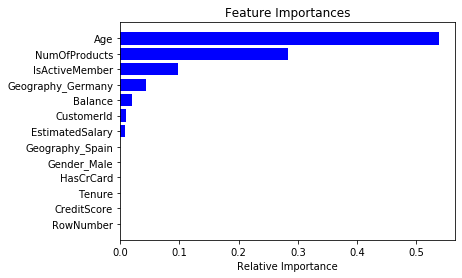

In [117]:
import matplotlib.pyplot as plt
features=features_test.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')